To do : 
- We stay on the "full" version of the data for now (with baseline) 
- Find a set of parameters for the TF analysis that doesn't include every time points, for example 20 ms  ; then the temporal dimension should look like : 40 to 60 ms, 60 to 80 ms, 80 to 100 ms, 100 to 120 ms, 120 to 140 ms for the post stim
- Perform clustering analysis separately for each of these 20 ms wide time windows, on phase / frequency data
- frequency domain : 8 Hz to 28 Hz 
- How to go to the group level ? If we find clusters, we could use centroids the group level.




In [4]:
import scipy.io as sio

In [13]:
#matfile = '/run/media/nfarrugi/ECHACHACHOU/PD_phase/data_probands_beta_noselec_p50_Cz_6_Hz.mat'
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/spectrum-beta-29feb2016/2017/wideband/data_probands_beta_noselec_p50_Cz.mat'

In [14]:
filecontents = sio.whosmat(matfile)
print(filecontents)

[('plv_subj_01k1', (1, 1), 'struct'), ('plv_subj_02k1', (1, 1), 'struct'), ('plv_subj_03k1', (1, 1), 'struct'), ('plv_subj_04k1', (1, 1), 'struct'), ('plv_subj_05k1', (1, 1), 'struct'), ('plv_subj_06k1', (1, 1), 'struct'), ('plv_subj_07k1', (1, 1), 'struct'), ('plv_subj_08k1', (1, 1), 'struct'), ('plv_subj_09k1', (1, 1), 'struct'), ('plv_subj_10k1', (1, 1), 'struct'), ('plv_subj_11k1', (1, 1), 'struct'), ('plv_subj_12k1', (1, 1), 'struct'), ('plv_subj_13k1', (1, 1), 'struct'), ('plv_subj_14k1', (1, 1), 'struct'), ('plv_subj_15k1', (1, 1), 'struct'), ('plv_subj_16k1', (1, 1), 'struct'), ('plv_subj_17k1', (1, 1), 'struct'), ('plv_subj_18k1', (1, 1), 'struct'), ('plv_subj_19k1', (1, 1), 'struct'), ('plv_subj_20k1', (1, 1), 'struct')]


Let's pick one subject randomly

In [182]:
import numpy as np 

cursubjname = filecontents[np.random.randint(20)][0]
print(cursubjname)

plv_subj_16k1


Load this subject

In [183]:
subjdata = sio.loadmat(matfile,variable_names=cursubjname,struct_as_record = False,squeeze_me=True)[cursubjname]

We can now directly access all the fields of the struct directly like in Matlab

Let's first select a particular time point to start with, say, 50 ms

In [184]:
subjdata.all.iso.standard.time

array([-0.2 , -0.18, -0.16, -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04,
       -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
        0.16,  0.18,  0.2 ])

In [185]:
allfreqs  = np.round(subjdata.all.iso.standard.freq)
print(allfreqs)

[  8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.
  23.  24.  25.  26.  27.  28.]


In [186]:
subjdata.all.iso.standard.time[14]

0.079999999998099147

In [41]:
subjdata.all.iso.standard.label

array(['Fz', 'Cz', 'Pz'], dtype=object)

Cz is label 1 

the "ang" field will fetch the angle data

In [187]:
p50_cz_iso_std = subjdata.all.iso.standard.ang[:,1,:,13]

In [188]:
p50_cz_iso_std.shape

(247, 21)

Trials are n_samples, and n_features is the number of frequencies. 

Do the same for RND std

In [189]:
p50_cz_rnd_std = subjdata.all.rnd.standard.ang[:,1,:,13]
p50_cz_rnd_std.shape

(245, 21)

Decoding tests on raw angle data
--

In this section, we are doing some basic decoding tests on specific time points, by looking at distributions of frequencies - at one specific time point, we see frequencies as features, and investigate whether the variability across trials can distinguish REGULAR vs IRREGULAR

Build the y vector (will be 1 for iso and 2 for rnd)

In [45]:
n_iso = p50_cz_iso_std.shape[0]
n_rnd = p50_cz_rnd_std.shape[0]
print(n_iso,n_rnd)

y = 2*np.ones(n_iso+n_rnd)
y[0:n_iso]=1

176 213


Build the X vector by just concatenating vertically the previous ones 

In [150]:
X = np.tan(np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))
print(X.shape)

(389, 21)


In [148]:
from matplotlib import pyplot as plt 
%matplotlib inline

Let's quickly have a look at the distributions before doing decoding

It looks like for the high frequencies, the distributions are far from normal. Let's do the same by separating conditions 

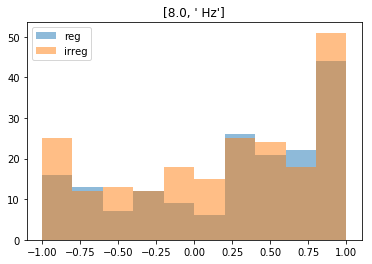

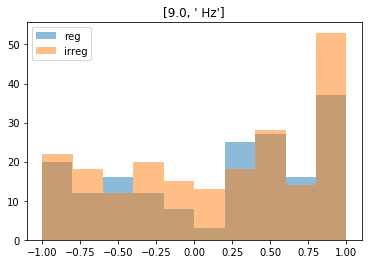

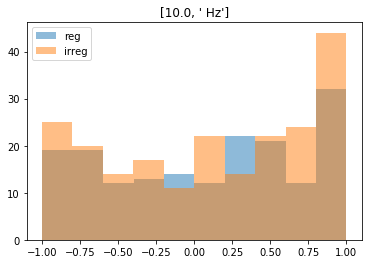

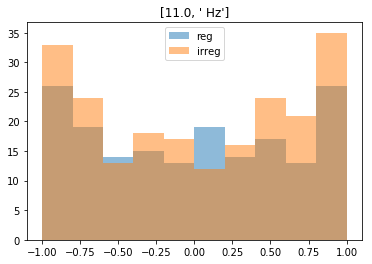

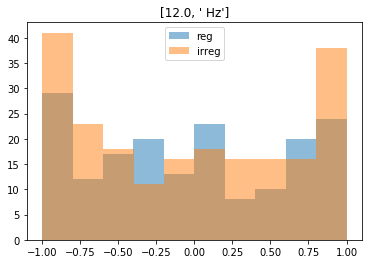

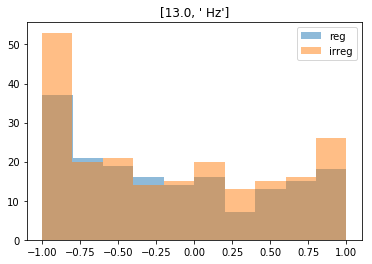

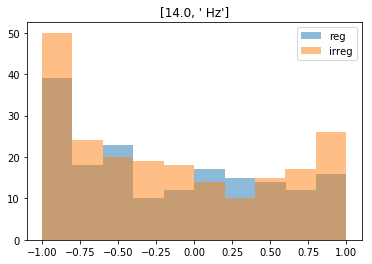

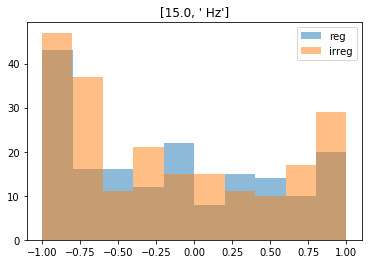

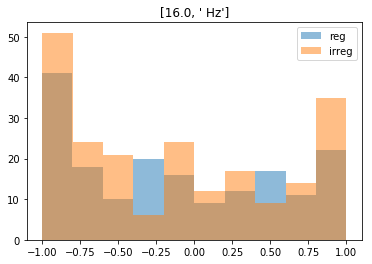

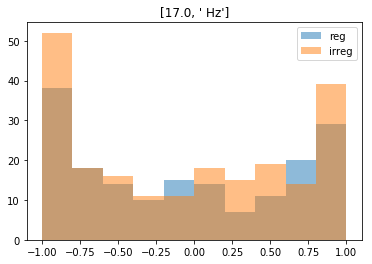

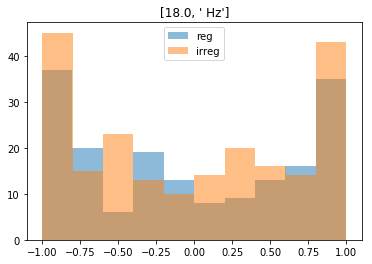

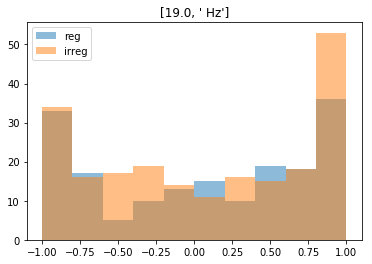

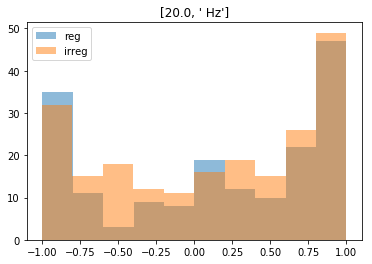

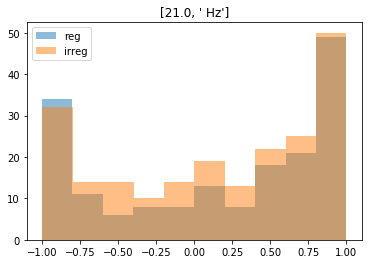

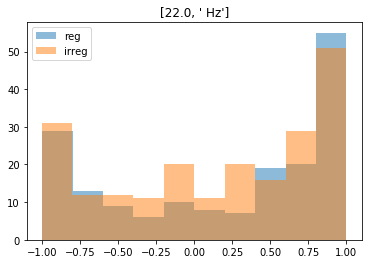

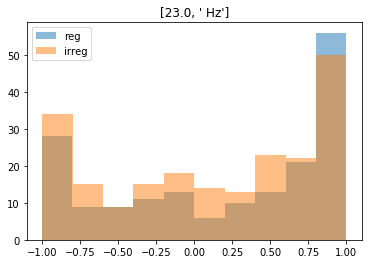

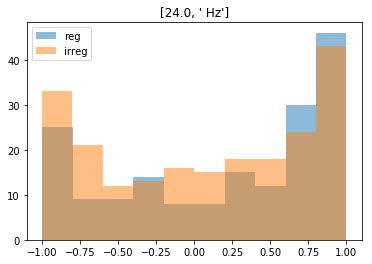

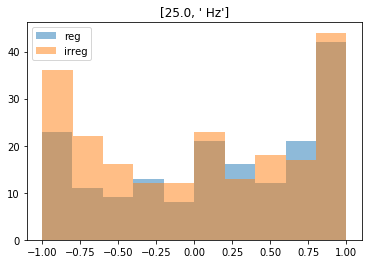

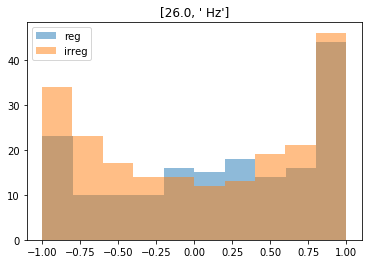

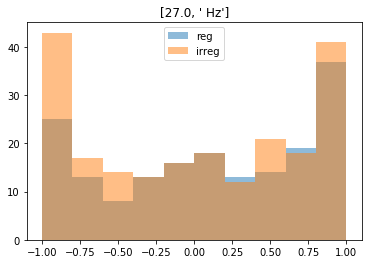

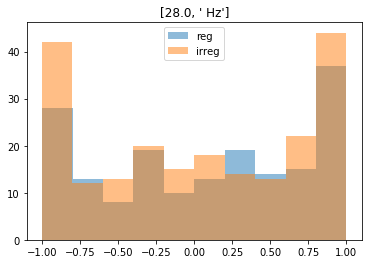

In [122]:
for curX1,curX2,curfreq in zip(p50_cz_iso_std.T,p50_cz_rnd_std.T,allfreqs):
    plt.hist(np.sin(curX1),alpha=0.5)
    plt.hist(np.sin(curX2),alpha=0.5)
    plt.title([curfreq,' Hz'])
    plt.legend(['reg','irreg'])
    plt.show()
    

There may be a few features that are discriminative. Let's try to train a classifier

In [181]:
#scaler = StandardScaler()
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.cross_validation import cross_val_score

X = (np.vstack([p50_cz_iso_std,p50_cz_rnd_std]))

quantiler = QuantileTransformer(n_quantiles=100,output_distribution='normal')

svm= SVC(kernel="poly")

my_nn = KNeighborsClassifier()
k=10
feature_selection = SelectKBest(f_classif, k=k)

pipeline_anova1 = Pipeline([('anova', feature_selection), ('scale', scaler),('classif_name', svm)])
pipeline_anova2 = Pipeline([('scale', scaler),('classif_name', svm)])
pipeline_anova4 = Pipeline([('classif_name', svm)])
pipeline_anova3 = Pipeline([('scale', scaler),('classif_name', my_nn)])


cvk = 5

scores = cross_val_score(pipeline_anova1,X,y,cv=cvk)

print(scores.mean())


scores = cross_val_score(pipeline_anova2,X,y,cv=cvk)

print(scores.mean())


scores = cross_val_score(pipeline_anova3,X,y,cv=cvk)

print(scores.mean())

scores = cross_val_score(pipeline_anova4,X,y,cv=cvk)

print(scores.mean())

0.534535928207
0.535095284462
0.483514375919
0.506790256157


In [166]:
### Single test

from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


## Train 


pipeline_anova.fit(X_train,y_train)

## and test

y_pred = pipeline_anova.predict(X_test)

accuracy_score(y_true=y_test,y_pred=y_pred)

0.58974358974358976

In [169]:

cross_val_score?

This doesn't give very promising results